In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, mutual_info_score, roc_auc_score

%matplotlib inline

# Data preparation

In [2]:
remote_csv = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

!wget $remote_csv -O data.csv

--2023-10-09 23:14:14--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  8.75MB/s    in 0.2s    

2023-10-09 23:14:14 (8.75 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [3]:
orig_df = pd.read_csv('data.csv')
orig_df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
orig_df.columns = orig_df.columns.str.replace(' ', '_').str.lower()
orig_df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
orig_df.isna().any()

make                 False
model                False
year                 False
engine_fuel_type      True
engine_hp             True
engine_cylinders      True
transmission_type    False
driven_wheels        False
number_of_doors       True
market_category       True
vehicle_size         False
vehicle_style        False
highway_mpg          False
city_mpg             False
popularity           False
msrp                 False
dtype: bool

In [6]:
orig_df = orig_df.fillna(0)

In [7]:
orig_df.isna().any()

make                 False
model                False
year                 False
engine_fuel_type     False
engine_hp            False
engine_cylinders     False
transmission_type    False
driven_wheels        False
number_of_doors      False
market_category      False
vehicle_size         False
vehicle_style        False
highway_mpg          False
city_mpg             False
popularity           False
msrp                 False
dtype: bool

In [8]:
orig_df = orig_df.rename(columns={'msrp': 'price'})
orig_df.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'price'],
      dtype='object')

In [9]:
hw_columns = ['make', 'model', 'year', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'price']
df_prep = orig_df.copy()
df_prep = df_prep[hw_columns]
df_prep.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [10]:
price_mean = df_prep.price.mean()
price_above_avg = (df_prep.price > price_mean)
df_prep['above_average'] = price_above_avg.astype(int)
df_prep.above_average

0        1
1        1
2        0
3        0
4        0
        ..
11909    1
11910    1
11911    1
11912    1
11913    0
Name: above_average, Length: 11914, dtype: int64

In [11]:
seed = 1

df_full_train, df_test = train_test_split(df_prep, test_size=0.2,random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['price']
del df_val['price']
del df_test['price']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

df_train.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
1,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
2,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
3,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
4,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17


In [12]:
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [13]:
def train(df_train, y_train, categorical=categorical, numerical=numerical, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model, categorical=categorical, numerical=numerical):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

# Question 1

In [14]:
for numeric_col in numerical:
    # omit categorical altogether. this makes the training much faster (fewer categories
    # because of the model column) and also scales the features
    dv, model = train(df_train, y_train, categorical=[], numerical=[numeric_col])
    y_pred = predict(df_val, dv, model, categorical=[], numerical=[numeric_col])

    auc_score = roc_auc_score(y_val, y_pred)
    if auc_score < 0.5:
        auc_score = -auc_score
    print(numeric_col, auc_score)

# engine_hp is has the highest auc

year -0.3091943868138943
engine_hp 0.9153308465235073
engine_cylinders 0.7690689320336834
highway_mpg 0.6286428845579014
city_mpg 0.6699949414821458


# Question 2

In [15]:
def train(df_train, y_train, categorical=categorical, numerical=numerical, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model, categorical=categorical, numerical=numerical):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [16]:
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)

auc_score = roc_auc_score(y_val, y_pred)
round(auc_score, 3)

0.977

# Question 3

In [17]:
step = 0.01
thresholds = np.arange(1.01, step=step)
len(thresholds), thresholds

(101,
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]))

In [18]:
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

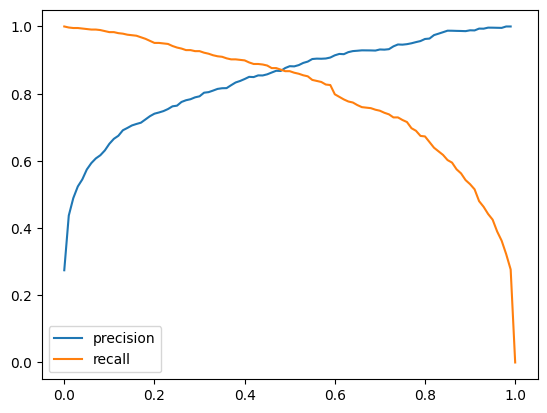

In [19]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

# threshold is ~0.5

# Question 4

In [20]:
# f1_score = (precision * recall) / (precision + recall)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['f1'] = (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

threshold       0.500000
tp            567.000000
fp             76.000000
fn             87.000000
tn           1653.000000
precision       0.881804
recall          0.866972
f1              0.437163
Name: 50, dtype: float64

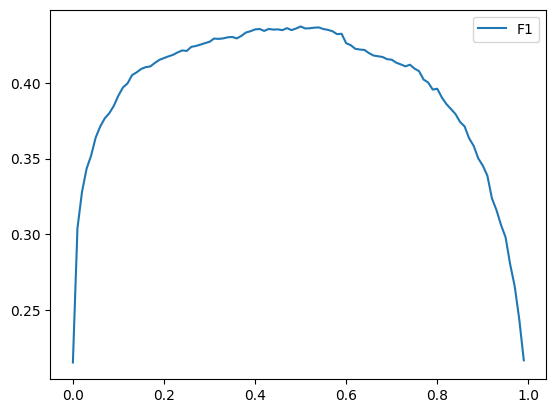

In [21]:
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')

plt.legend()

df_scores.iloc[df_scores['f1'].idxmax()]

# Question 5

In [27]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [28]:
splits = 5
C = 1.0

kfold = KFold(n_splits=splits, shuffle=True, random_state=1)

auc_scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    score = roc_auc_score(y_val, y_pred)
    auc_scores.append(score)
print('C=%s %.3f +- %.3f' % (C, np.mean(auc_scores), np.std(auc_scores)))

C=1.0 0.978 +- 0.001


# Question 6

In [24]:
splits = 5
C = [0.01, 0.1, 0.5, 10]

for c in C:
    kfold = KFold(n_splits=splits, shuffle=True, random_state=1)
    
    auc_scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
    
        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)
    
        score = roc_auc_score(y_val, y_pred)
        auc_scores.append(score)
    print('C=%s %.3f +- %.3f' % (c, np.mean(auc_scores), np.std(auc_scores)))

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.001
C=10 0.980 +- 0.003
